In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns 
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
import statsmodels.api as sm

**Info about original data:**
- Original data = Headway Data, 8-1-2023 to 9-30-2023.xlsx
- Number of observations: 350,328 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350328 entries, 0 to 350327
Data columns (total 30 columns):
Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   CALENDAR_ID                350328 non-null  int64         
 1   SERVICE_ABBR               350328 non-null  int64         
 2   ADHERENCE_ID               350328 non-null  int64         
 3   DATE                       350328 non-null  datetime64[ns]
 4   ROUTE_ABBR                 350328 non-null  int64         
 5   BLOCK_ABBR                 350328 non-null  int64         
 6   OPERATOR                   350328 non-null  int64         
 7   TRIP_ID                    350328 non-null  int64         
 8   OVERLOAD_ID                350328 non-null  int64         
 9   ROUTE_DIRECTION_NAME       350328 non-null  object        
 10  TIME_POINT_ABBR            350328 non-null  object        
 11  ROUTE_STOP_SEQUENCE        350317 non-null  float64       
 12  TRIP_EDGE                  350328 non-null  int64         
 13  LATITUDE                   350328 non-null  float64       
 14  LONGITUDE                  350328 non-null  float64       
 15  SCHEDULED_TIME             350328 non-null  object        
 16  ACTUAL_ARRIVAL_TIME        338869 non-null  object        
 17  ACTUAL_DEPARTURE_TIME      338860 non-null  object        
 18  ADHERENCE                  338860 non-null  float64       
 19  SCHEDULED_HDWY             274737 non-null  float64       
 20  ACTUAL_HDWY                266061 non-null  float64       
 21  HDWY_DEV                   265892 non-null  float64       
 22  ADJUSTED_EARLY_COUNT       350328 non-null  int64         
 23  ADJUSTED_LATE_COUNT        350328 non-null  int64         
 24  ADJUSTED_ONTIME_COUNT      350328 non-null  int64         
 25  STOP_CANCELLED             350328 non-null  int64         
 26  PREV_SCHED_STOP_CANCELLED  279999 non-null  float64       
 27  IS_RELIEF                  350328 non-null  int64         
 28  BLOCK_STOP_ORDER           350328 non-null  int64         
 29  DWELL_IN_MINS              338857 non-null  float64 
 
- We removed null values because there were only 265,892 observations with existing HDWY_DEV columns. New dataframe -> headway_data, 265884 entries (75.89%)
- Also removed outliers from the HDWY_DEV and ADHERENCE columns. New dataframe -> processed_data, 254299 entries (72% of original data OR 95.64% of data after removing null values). 
- Data cleanup was based on keeping the 99.9th percentile of the data's HDWY_DEV and ADHERENCE z-scores. Dataset was grouped into each UNIQUE_TRIP_ID (this is the unique ID for each trip on a specific day; trip numbers were reused after a couple days). Z-scores were calculated for the HDWY_DEV and ADHERENCE columns and if the values fell outside of the 99.9th percentile, which meant values below the 0.1st percentile and above the 99.9th percentile. 

In [2]:
processed_data = pd.read_csv("../data/processed_data.csv")
processed_data.head(2)

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,PREV_SCHED_STOP_CANCELLED,IS_RELIEF,BLOCK_STOP_ORDER,DWELL_IN_MINS,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,80,0.0,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.0,0,70,0.0,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666


**Question:** What is the relationship between adherence and headway deviation? 

In [43]:
lm = smf.ols('HDWY_DEV ~ ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.193
Model:                            OLS   Adj. R-squared:                  0.193
Method:                 Least Squares   F-statistic:                 6.073e+04
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:27:20   Log-Likelihood:            -7.3185e+05
No. Observations:              254299   AIC:                         1.464e+06
Df Residuals:                  254297   BIC:                         1.464e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.6159      0.011   -145.315      0.000      -1.638      -1.594
ADHERENCE     -0.5678      0.002   -246.427      0.000      -0.572      -0.563
==============================================================================
Omnibus:                    40022.024   Durbin-Watson:                   0.933
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           317317.174
Skew:                          -0.533   Prob(JB):                         0.00
Kurtosis:                       8.367   Cond. No.                         6.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Results:**
- The F-statistic is a test statistic used to assess the overall significance of the model. The F-statistic is 6.073e+04, and the p-value is 0.00, indicating that the model is statistically significant.
- The **intercept** is the predicted value of 'HDWY_DEV' when 'ADHERENCE' is zero.
- Both coefficients have very low p-values (close to 0), indicating that they are **statistically significant**.
- R-squared of 0.193, indicate that approximately 19.3% of the variance in HDWY_DEV is explained by the model.

mean(ADHERENCE) = -1.6159 - 0.5678(HDWY_DEV)

- For every one-minute change in 'ADHERENCE', 'HDWY_DEV' is expected to decrease by approximately -0.5678 minutes (or about 34 seconds). The negative sign means that as 'ADHERENCE' increases (the bus leaves before the scheduled time), 'HDWY_DEV' is expected to decrease (become more negative).

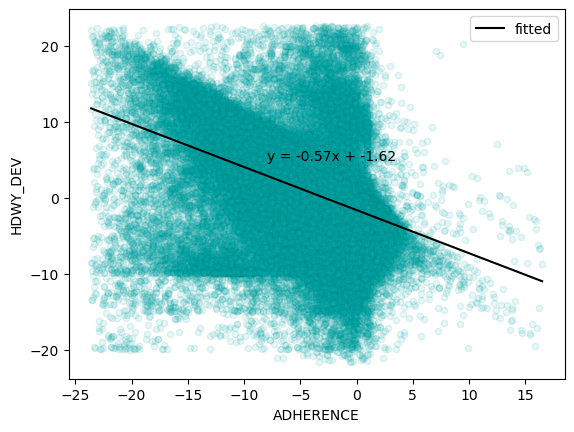

In [44]:
m = lm.params['ADHERENCE']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'ADHERENCE', y = 'HDWY_DEV', kind = 'scatter', s = 20, color = 'c', edgecolor = 'teal', linewidth=1, alpha=0.1); #cyan
ax.text(
    -8, 5, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'ADHERENCE': np.linspace(
        start = processed_data['ADHERENCE'].min(),
        stop = processed_data['ADHERENCE'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'ADHERENCE', y = 'fitted', ax = ax, color = 'black', label = 'fitted');

plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/adherence_vs_hdwydev2.png');

**Question:** What is the relationship between previous adherence on the next adherence? 

In [49]:
# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['PREVIOUS_ADHERENCE'].corr(processed_data['NEXT_ADHERENCE'])
print("Correlation between first stop adherence and next stop adherence:", correlation)

Correlation between first stop adherence and next stop adherence: 0.700549331688534


In [45]:
lm = smf.ols('NEXT_ADHERENCE ~ PREVIOUS_ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         NEXT_ADHERENCE   R-squared:                       0.491
Model:                            OLS   Adj. R-squared:                  0.491
Method:                 Least Squares   F-statistic:                 1.256e+05
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:33:41   Log-Likelihood:            -3.1772e+05
No. Observations:              130280   AIC:                         6.355e+05
Df Residuals:                  130278   BIC:                         6.355e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.9873      0.010    -97.255      0.000      -1.007      -0.967
PREVIOUS_ADHERENCE     0.7467      0.002    354.337      0.000       0.743       0.751
==============================================================================
Omnibus:                    34921.944   Durbin-Watson:                   1.498
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           261722.936
Skew:                          -1.089   Prob(JB):                         0.00
Kurtosis:                       9.593   Cond. No.                         6.49
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

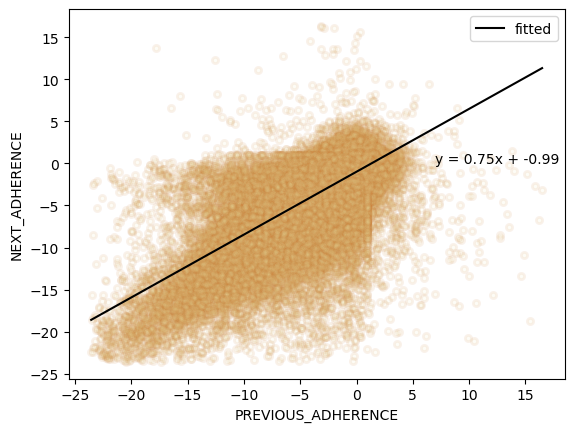

In [46]:
m = lm.params['PREVIOUS_ADHERENCE']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'PREVIOUS_ADHERENCE', y = 'NEXT_ADHERENCE', kind = 'scatter', s = 20, color = 'palegoldenrod', edgecolor = 'peru', linewidth=2, alpha = 0.1)

ax.text(
    7, 0, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'PREVIOUS_ADHERENCE': np.linspace(
        start = processed_data['PREVIOUS_ADHERENCE'].min(),
        stop = processed_data['PREVIOUS_ADHERENCE'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'PREVIOUS_ADHERENCE', y = 'fitted', ax = ax, color = 'black', label = 'fitted');

plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/prevadherence_vs_nextadherence2.png');

**Question:** What is the relationship between previous headway deviation on next headway deviation? 

In [6]:
# Calculate lagged adherence values for each stop
processed_data['PREVIOUS_HDWY_DEV'] = processed_data.groupby('UNIQUE_TRIP_ID')['HDWY_DEV'].shift(1)
processed_data['NEXT_HDWY_DEV'] = processed_data.groupby('UNIQUE_TRIP_ID')['HDWY_DEV'].shift(-1)

# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['PREVIOUS_HDWY_DEV'].corr(processed_data['NEXT_HDWY_DEV'])
print("Correlation between first stop headway deviation and next stop headway deviation:", correlation)

Correlation between first stop headway deviation and next stop headway deviation: 0.545366112026422


In [38]:
lm = smf.ols('NEXT_HDWY_DEV ~ PREVIOUS_HDWY_DEV', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          NEXT_HDWY_DEV   R-squared:                       0.297
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                 5.515e+04
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:22:23   Log-Likelihood:            -3.6983e+05
No. Observations:              130280   AIC:                         7.397e+05
Df Residuals:                  130278   BIC:                         7.397e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.0514      0.011      4.481      0.000       0.029       0.074
PREVIOUS_HDWY_DEV     0.5616      0.002    234.843      0.000       0.557       0.566
==============================================================================
Omnibus:                    18923.336   Durbin-Watson:                   1.531
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           224683.012
Skew:                           0.296   Prob(JB):                         0.00
Kurtosis:                       9.406   Cond. No.                         4.80
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

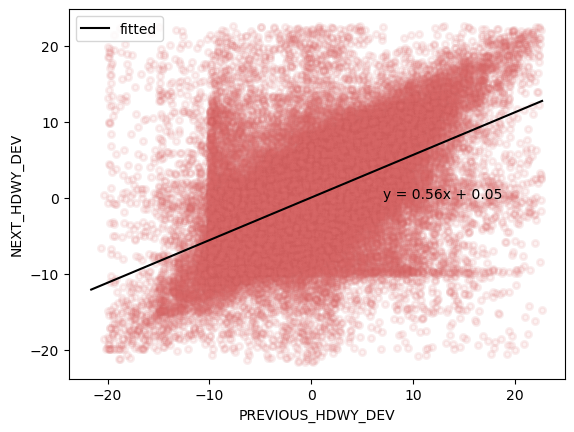

In [41]:
m = lm.params['PREVIOUS_HDWY_DEV']  # Slope
b = lm.params['Intercept']  # Y-intercept
equation = f'y = {m:.2f}x + {b:.2f}'

ax = processed_data.plot(x = 'PREVIOUS_HDWY_DEV', y = 'NEXT_HDWY_DEV', kind = 'scatter', s = 20, color = 'lightcoral', edgecolor = 'indianred', linewidth=2, alpha = 0.1)

ax.text(
    7, 0, # x and y coordinates
    equation,
    fontsize=10,
    color='black'
)

fit_df = pd.DataFrame({
    'PREVIOUS_HDWY_DEV': np.linspace(
        start = processed_data['PREVIOUS_HDWY_DEV'].min(),
        stop = processed_data['PREVIOUS_HDWY_DEV'].max(), 
        num = 150)})
fit_df['fitted'] = lm.predict(fit_df)

fit_df.plot(x = 'PREVIOUS_HDWY_DEV', y = 'fitted', ax = ax, color = 'black', label = 'fitted');

plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/prevhdwydev_vs_nexthdwydev2.png');

**Question:** What is the relationship between adherence on the next headway deviation? 

In [47]:
# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['ADHERENCE'].corr(processed_data['NEXT_HDWY_DEV'])
print("Correlation between first stop adherence and next stop adherence:", correlation)

Correlation between first stop adherence and next stop adherence: -0.36746911987986525


In [48]:
lm = smf.ols('NEXT_HDWY_DEV ~ ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          NEXT_HDWY_DEV   R-squared:                       0.135
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                 2.997e+04
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:45:48   Log-Likelihood:            -5.6121e+05
No. Observations:              191985   AIC:                         1.122e+06
Df Residuals:                  191983   BIC:                         1.122e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -1.3692      0.013   -101.808      0.000      -1.396      -1.343
ADHERENCE     -0.4915      0.003   -173.122      0.000      -0.497      -0.486
==============================================================================
Omnibus:                    19910.878   Durbin-Watson:                   1.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           135969.546
Skew:                          -0.257   Prob(JB):                         0.00
Kurtosis:                       7.091   Cond. No.                         6.32
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Question:** How does *operator* impact headway deviation? 

In [51]:
# Check correlation to see how adherence at the first trip's first stop influences the adherence at the next stop
correlation = processed_data['OPERATOR'].corr(processed_data['HDWY_DEV'])
print("Correlation between operator and headway deviation:", correlation)

Correlation between operator and headway deviation: -0.002593086270749733


How many unique operators are there? 

In [9]:
processed_data['OPERATOR'].nunique()

333

In [10]:
processed_data['OPERATOR'] = processed_data['OPERATOR'].astype('category')  

In [11]:
processed_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 254299 entries, 0 to 254298
Data columns (total 38 columns):
 #   Column                     Non-Null Count   Dtype   
---  ------                     --------------   -----   
 0   CALENDAR_ID                254299 non-null  int64   
 1   SERVICE_ABBR               254299 non-null  int64   
 2   ADHERENCE_ID               254299 non-null  int64   
 3   DATE                       254299 non-null  object  
 4   ROUTE_ABBR                 254299 non-null  int64   
 5   BLOCK_ABBR                 254299 non-null  int64   
 6   OPERATOR                   254299 non-null  category
 7   TRIP_ID                    254299 non-null  int64   
 8   OVERLOAD_ID                254299 non-null  int64   
 9   ROUTE_DIRECTION_NAME       254299 non-null  object  
 10  TIME_POINT_ABBR            254299 non-null  object  
 11  ROUTE_STOP_SEQUENCE        254299 non-null  float64 
 12  TRIP_EDGE                  254299 non-null  int64   
 13  LATITUDE      

**Linear regression**

In [12]:
lm = smf.ols('HDWY_DEV ~ OPERATOR', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     42.95
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:12:18   Log-Likelihood:            -7.5213e+05
No. Observations:              254299   AIC:                         1.505e+06
Df Residuals:                  253966   BIC:                         1.508e+06
Df Model:                         332                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2500      3.296     -0.076      0.940      -6.711       6.211
OPERATOR[T.235]      2.1685      3.644      0.595      0.552      -4.974       9.311
OPERATOR[T.244]      0.2125      3.457      0.061      0.951      -6.563       6.988
OPERATOR[T.301]      3.0822      3.404      0.905      0.365      -3.590       9.755
OPERATOR[T.304]      1.7516      3.298      0.531      0.595      -4.712       8.216
OPERATOR[T.326]      1.8757      3.298      0.569      0.570      -4.589       8.340
OPERATOR[T.329]     -1.7208      3.298     -0.522      0.602      -8.185       4.744
OPERATOR[T.332]      1.4489      3.298      0.439      0.660      -5.016       7.914
OPERATOR[T.341]      0.6855      3.300      0.208      0.835      -5.783       7.154
OPERATOR[T.357]      2.6641      3.299      0.808      0.419      -3.802       9.130
OPERATOR[T.359]      0.6620      3.300      0.201      0.841      -5.806       7.130
OPERATOR[T.375]      0.2183      3.611      0.060      0.952      -6.859       7.296
OPERATOR[T.379]      0.3959      3.298      0.120      0.904      -6.069       6.860
OPERATOR[T.409]      0.5389      3.298      0.163      0.870      -5.926       7.003
OPERATOR[T.414]     -0.1308      3.299     -0.040      0.968      -6.597       6.336
OPERATOR[T.465]     -1.1156      3.509     -0.318      0.751      -7.993       5.762
OPERATOR[T.471]      0.5722      3.302      0.173      0.862      -5.899       7.043
OPERATOR[T.517]     -0.5270      3.299     -0.160      0.873      -6.992       5.938
OPERATOR[T.520]     -0.4143      3.298     -0.126      0.900      -6.879       6.050
OPERATOR[T.522]     -0.6485      3.299     -0.197      0.844      -7.114       5.817
OPERATOR[T.559]      0.2411      3.298      0.073      0.942      -6.223       6.706
OPERATOR[T.572]      1.6140      3.301      0.489      0.625      -4.856       8.084
OPERATOR[T.611]     -0.4300      3.300     -0.130      0.896      -6.898       6.038
OPERATOR[T.624]     -0.5165      3.300     -0.156      0.876      -6.985       5.952
OPERATOR[T.653]      0.4533      3.322      0.136      0.891      -6.058       6.964
OPERATOR[T.659]     -1.6808      3.298     -0.510      0.610      -8.146       4.784
OPERATOR[T.723]     -1.4433      3.300     -0.437      0.662      -7.911       5.024
OPERATOR[T.778]     -0.3614      3.299     -0.110      0.913      -6.827       6.105
OPERATOR[T.785]     -0.7047      3.299     -0.214      0.831      -7.170       5.761
OPERATOR[T.907]     -0.2865      3.304     -0.087      0.931      -6.762       6.189
OPERATOR[T.1016]     1.8294      3.339      0.548      0.584      -4.716       8.375
OPERATOR[T.1040]     0.3644      3.299      0.110      0.912      -6.102       6.831
OPERATOR[T.1052]     0.0840      3.299      0.025      0.980      -6.381       6.549
OPERATOR[T.1078]     1.

**Statistics on OPERATOR dataframe**

In [13]:
# Grouping by OPERATOR and computing the mean, standard deviation, and count for HDWY_DEV and ADHERENCE
operator_stats = processed_data.groupby('OPERATOR').agg({
    'HDWY_DEV': [('mean_HDWY_DEV', 'mean'),
                 ('std_HDWY_DEV', 'std'),
                 ('count', 'count')],
    'ADHERENCE': [('mean_ADHERENCE', 'mean'),
                  ('std_ADHERENCE', 'std')]
}).reset_index()

# Rename columns 
operator_stats.columns = operator_stats.columns.droplevel(0)
operator_stats.rename(columns={'': 'OPERATOR'}, inplace=True)

operator_stats.head(10)

,OPERATOR,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE
0,56,-0.250000,0.730677,2,-1.391667,2.133105
1,235,1.918518,6.305770,9,-4.198148,4.327668
2,244,-0.037500,6.095262,20,-3.509166,4.600875
3,301,2.832222,7.116150,30,-4.615555,3.629435
4,304,1.501628,3.596538,1976,-3.095015,2.985387
5,326,1.625676,5.141692,1576,-4.286294,3.480703
6,329,-1.970809,4.377375,1710,-2.475117,3.150801
7,332,1.198889,4.258641,1590,-3.171593,3.736069
8,341,0.435464,3.188792,868,-1.791820,2.849767
9,357,2.414106,5.281714,1152,-5.763614,4.700579


**Question:** Which operators are the most at following headway to the scheduled headway? 

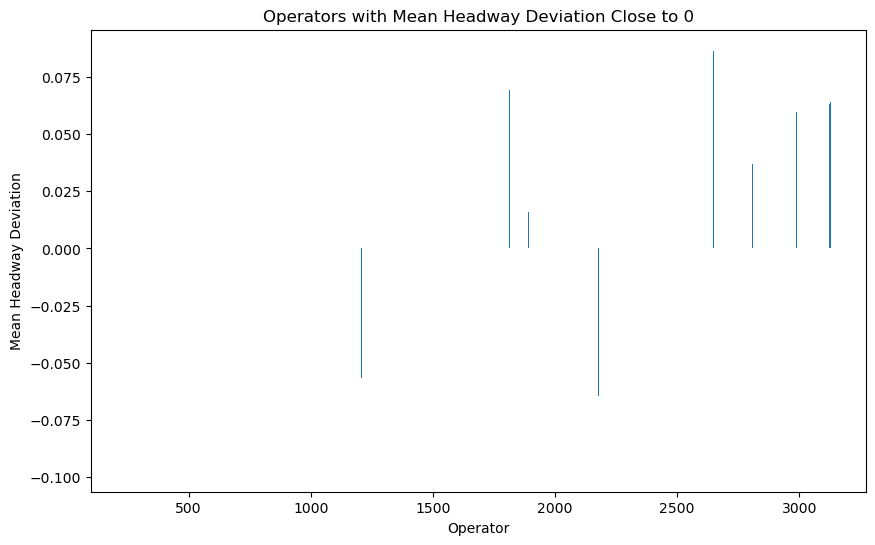

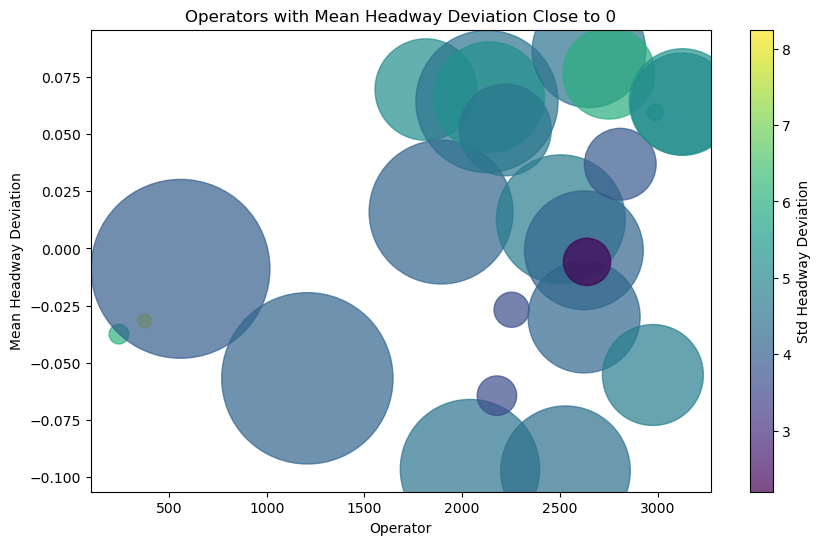

In [14]:
# Set the threshold for "close to 0"
threshold = 0.1

# Filter the DataFrame to find operators with mean headway deviation close to 0
close_to_0_operators = operator_stats[
    (operator_stats['mean_HDWY_DEV'] >= -threshold) & (operator_stats['mean_HDWY_DEV'] <= threshold)
]

# Create a bar plot to visualize mean headway deviations for close-to-0 operators
plt.figure(figsize=(10, 6))
plt.bar(close_to_0_operators['OPERATOR'], close_to_0_operators['mean_HDWY_DEV'])
plt.xlabel('Operator')
plt.ylabel('Mean Headway Deviation')
plt.title('Operators with Mean Headway Deviation Close to 0')
plt.show()

# Alternatively, you can create a scatter plot to visualize additional information
plt.figure(figsize=(10, 6))
plt.scatter(
    close_to_0_operators['OPERATOR'],
    close_to_0_operators['mean_HDWY_DEV'],
    s=close_to_0_operators['count'] * 10,  # Scale the marker size based on count
    c=close_to_0_operators['std_HDWY_DEV'],  # Color based on std_HDWY_DEV
    cmap='viridis',  # Colormap for color mapping
    alpha=0.7  # Transparency
)
plt.xlabel('Operator')
plt.ylabel('Mean Headway Deviation')
plt.title('Operators with Mean Headway Deviation Close to 0')
plt.colorbar(label='Std Headway Deviation')
plt.show()

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/images/operators_w_mean_hdwydev_close_to_zero.png');

threshold = 0.1

close_to_0_operators = operator_stats[
    (operator_stats['mean_HDWY_DEV'] >= -threshold) & (operator_stats['mean_HDWY_DEV'] <= threshold)
]


plt.figure(figsize=(10, 6))
plt.bar(
    close_to_0_operators['OPERATOR'],
    close_to_0_operators['mean_HDWY_DEV'],
    alpha=0.7,  # Transparency
    bottom=0  # Set the bottom of the bars to 0
)
plt.xlabel('Operator')
plt.ylabel('Mean Headway Deviation')
plt.title('Operators with Mean Headway Deviation Close to 0')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)

plt.show()

In [16]:
close_to_0_operators.head()

,OPERATOR,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE
2,244,-0.037500,6.095262,20,-3.509166,4.600875
11,375,-0.031667,8.245756,10,-2.811666,2.582396
20,559,-0.008927,3.987104,1658,-3.381353,3.500004
44,1208,-0.056822,4.159245,1522,-1.941382,2.696841
110,1814,0.069475,5.151291,534,-3.342821,4.163961


In [20]:
import matplotlib.pyplot as plt

# Order the dataframe by mean headway deviation and then by count headway deviation in descending order
operators_stats_sorted_hdwy_dev = operator_stats.iloc[abs(operator_stats['mean_HDWY_DEV']).argsort()].sort_values(by='count', ascending=False)

operators_stats_sorted_hdwy_dev.head(10)

,OPERATOR,mean_HDWY_DEV,std_HDWY_DEV,count,mean_ADHERENCE,std_ADHERENCE
48,1266,-0.299725,4.346272,2365,-2.585941,2.453786
34,1133,-0.350705,3.792212,2177,-1.568244,2.181407
4,304,1.501628,3.596538,1976,-3.095015,2.985387
194,2399,-2.207886,5.371972,1972,-2.541979,3.540465
129,1927,-1.534390,3.503598,1910,-1.283333,1.684347
88,1650,1.061940,4.677132,1876,-4.195069,4.755937
74,1566,-0.437639,2.637647,1835,-1.455022,1.690599
66,1410,0.950318,3.816506,1835,-3.614950,2.355233
196,2424,0.184334,4.709914,1781,-2.962203,3.166150
18,520,-0.664293,4.776342,1769,-4.299981,4.276415


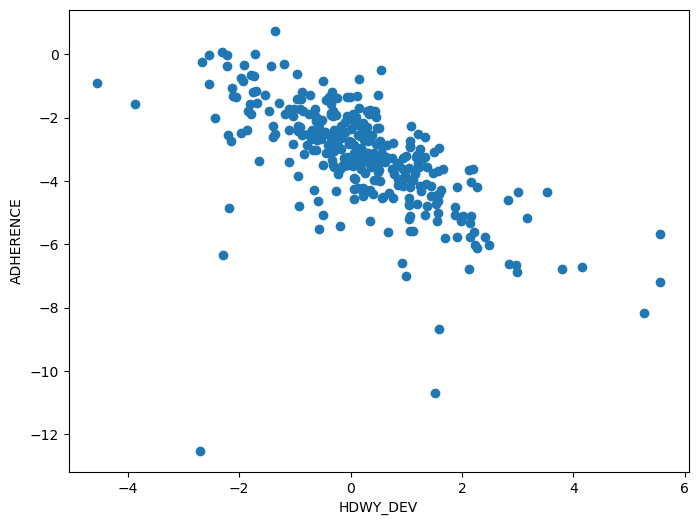

In [19]:
plt.figure(figsize=(8, 6))
plt.scatter(operator_stats['mean_HDWY_DEV'], operator_stats['mean_ADHERENCE'])
plt.xlabel("HDWY_DEV")
plt.ylabel("ADHERENCE")
plt.show()

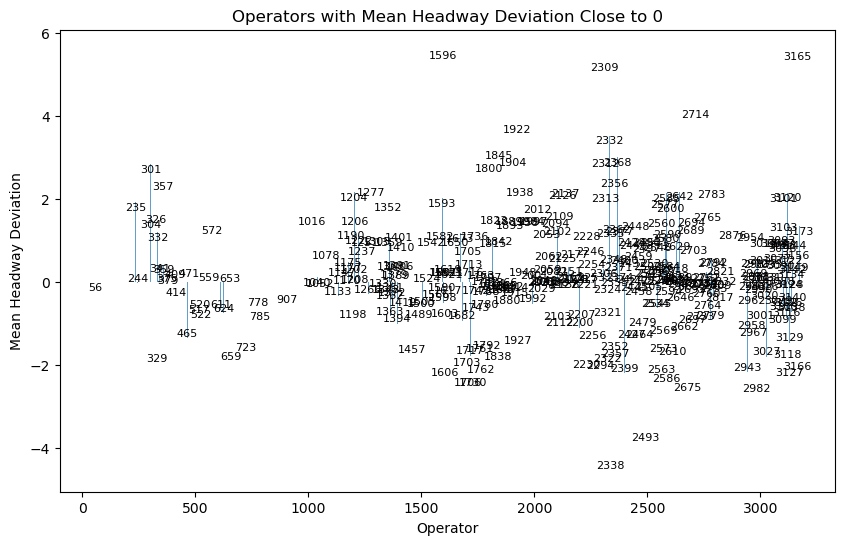

In [21]:

# Create a bar plot to visualize mean headway deviations for close-to-0 operators
plt.figure(figsize=(10, 6))
bars = plt.bar(
    operators_stats_sorted_hdwy_dev['OPERATOR'],
    operators_stats_sorted_hdwy_dev['mean_HDWY_DEV'],
    alpha=0.7
)

# Add labels at the top of the bars
for bar, label in zip(bars, operators_stats_sorted_hdwy_dev['OPERATOR']):
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        label,
        ha='center',  # Horizontal alignment
        va='bottom' if height < 0 else 'top',  # Vertical alignment
        fontsize=8  # Adjust the font size as needed
    )

plt.xlabel('Operator')
plt.ylabel('Mean Headway Deviation')
plt.title('Operators with Mean Headway Deviation Close to 0')
plt.show()

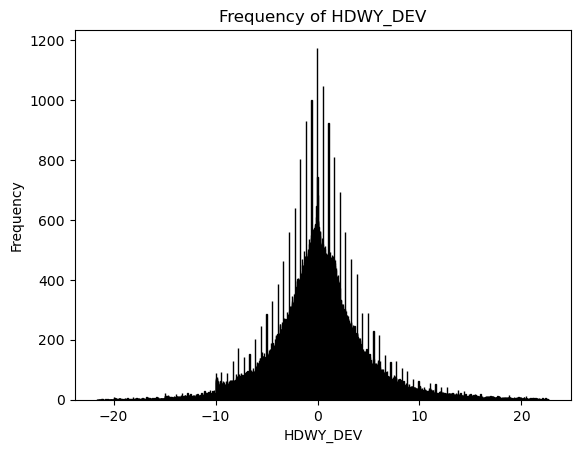

In [22]:
plt.hist(processed_data['HDWY_DEV'], bins=len(processed_data['HDWY_DEV'].unique()), edgecolor='k')
plt.xlabel('HDWY_DEV')
plt.ylabel('Frequency')
plt.title('Frequency of HDWY_DEV')
plt.show()


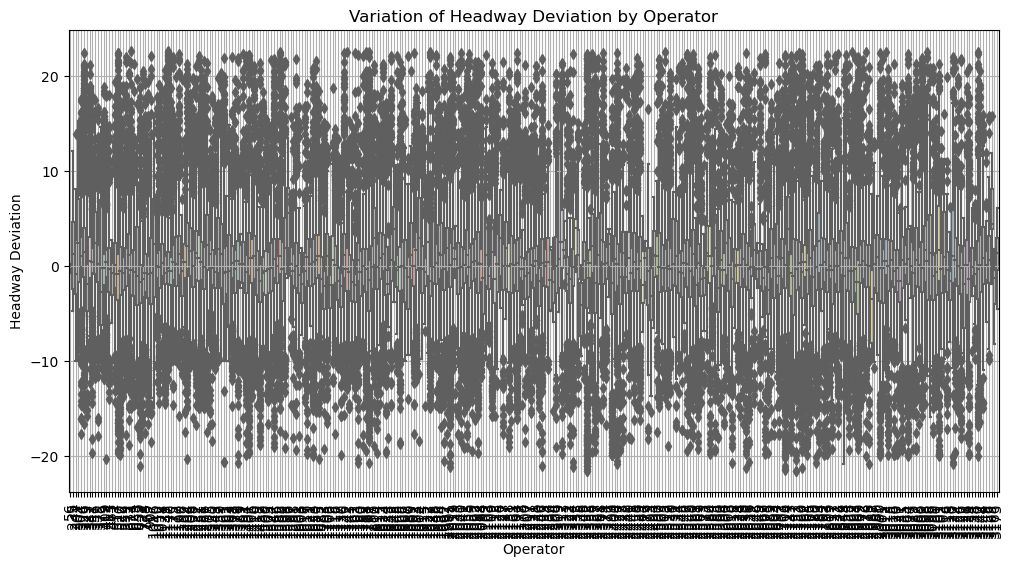

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=processed_data, x='OPERATOR', y='HDWY_DEV', palette='Set3')
plt.xlabel('Operator')
plt.ylabel('Headway Deviation')
plt.title('Variation of Headway Deviation by Operator')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

**Question:** Does the operator have any impact on the NEXT_ADHERENCE based on its PREVIOUS_ADHERENCE? 

In [24]:
lm = smf.ols('NEXT_ADHERENCE ~ OPERATOR + PREVIOUS_ADHERENCE', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         NEXT_ADHERENCE   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.506
Method:                 Least Squares   F-statistic:                     418.7
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:19:00   Log-Likelihood:            -3.1563e+05
No. Observations:              130280   AIC:                         6.319e+05
Df Residuals:                  129960   BIC:                         6.350e+05
Df Model:                         319                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -1.8746      2.732     -0.686      0.493      -7.229       3.480
OPERATOR[T.235]       -3.1899      3.054     -1.044      0.296      -9.176       2.797
OPERATOR[T.244]       -0.2451      2.844     -0.086      0.931      -5.818       5.328
OPERATOR[T.301]        0.1607      2.807      0.057      0.954      -5.341       5.662
OPERATOR[T.304]        1.0508      2.733      0.384      0.701      -4.306       6.408
OPERATOR[T.326]        0.0618      2.734      0.023      0.982      -5.297       5.420
OPERATOR[T.329]        1.4117      2.733      0.516      0.606      -3.946       6.769
OPERATOR[T.332]        0.3991      2.733      0.146      0.884      -4.958       5.756
OPERATOR[T.341]     -6.17e-14   2.25e-13     -0.274      0.784   -5.02e-13    3.79e-13
OPERATOR[T.357]       -0.3922      2.734     -0.143      0.886      -5.751       4.967
OPERATOR[T.359]        0.7894      2.735      0.289      0.773      -4.571       6.150
OPERATOR[T.375]        0.2517      2.951      0.085      0.932      -5.532       6.035
OPERATOR[T.379]        1.1935      2.734      0.436      0.662      -4.166       6.553
OPERATOR[T.409]        0.6905      2.734      0.253      0.801      -4.667       6.048
OPERATOR[T.414]        1.1544      2.734      0.422      0.673      -4.205       6.514
OPERATOR[T.465]        4.0101      2.880      1.393      0.164      -1.634       9.654
OPERATOR[T.471]        0.6418      2.736      0.235      0.815      -4.721       6.005
OPERATOR[T.517]        0.7067      2.734      0.259      0.796      -4.651       6.065
OPERATOR[T.520]        0.6698      2.733      0.245      0.806      -4.687       6.027
OPERATOR[T.522]        1.3639      2.734      0.499      0.618      -3.994       6.722
OPERATOR[T.559]        0.7644      2.733      0.280      0.780      -4.593       6.122
OPERATOR[T.572]        0.5837      2.737      0.213      0.831      -4.780       5.947
OPERATOR[T.611]        0.5257      2.735      0.192      0.848      -4.835       5.886
OPERATOR[T.624]        0.9791      2.735      0.358      0.720      -4.381       6.340
OPERATOR[T.653]        1.8120      2.751      0.659      0.510      -3.580       7.204
OPERATOR[T.659]        1.6756      2.733      0.613      0.540      -3.682       7.033
OPERATOR[T.723]    -1.295e-13   4.95e-13     -0.261      0.794    -1.1e-12    8.41e-13
OPERATOR[T.778]        1.0046      2.734      0.367      0.713      -4.354       6.364
OPERATOR[T.785]        1.2047      2.734      0.441      0.659      -4.154       6.563
OPERATOR[T.907]        0.9836      2.738      0.359      0.719      -4.383       6.350
OPERATOR[T.1016]       0.1580      2.758      0.057      0.954      -5.248       5.564
OPERATOR[T.1040]       1.4691      2.742      0.536      0.592      -3.905       6.843
OPERATOR[T.1052]       0.9140      2.7

**Results:**
- R-squared of 0.492: this model explains about 49.2% of the variance in NEXT_ADHERENCE. 
- With a large F-statistic and a very low F-statistic p-value, this means this model is statistically significant. 
- The p-values associated with the t-statistics are very low (close to 0), which means that they're statistically significant. 

mean(NEXT_ADHERENCE) = -0.7095(NEXT_ADHERENCE) - .0001(OPERATOR) + .7451(PREVIOUS_ADHERENCE)
- For every unit change in PREVIOUS_ADHERENCE, NEXT_ADHERENCE is supposed to increase by .7451 units. With the OPERATOR being so close to zero, this means that it has no impact on NEXT_ADHERENCE. 

In [25]:
lm = smf.ols('NEXT_HDWY_DEV ~ OPERATOR + PREVIOUS_HDWY_DEV', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          NEXT_HDWY_DEV   R-squared:                       0.311
Model:                            OLS   Adj. R-squared:                  0.310
Method:                 Least Squares   F-statistic:                     184.3
Date:                Mon, 13 Nov 2023   Prob (F-statistic):               0.00
Time:                        11:19:09   Log-Likelihood:            -3.6851e+05
No. Observations:              130280   AIC:                         7.377e+05
Df Residuals:                  129960   BIC:                         7.408e+05
Df Model:                         319                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.2605      4.100     -0.064      0.949      -8.296       7.775
OPERATOR[T.235]      -0.7785      4.584     -0.170      0.865      -9.762       8.205
OPERATOR[T.244]       2.1110      4.267      0.495      0.621      -6.252      10.474
OPERATOR[T.301]       2.2668      4.212      0.538      0.590      -5.989      10.522
OPERATOR[T.304]       0.9693      4.101      0.236      0.813      -7.069       9.008
OPERATOR[T.326]       0.8373      4.103      0.204      0.838      -7.204       8.878
OPERATOR[T.329]      -0.3416      4.102     -0.083      0.934      -8.381       7.698
OPERATOR[T.332]       1.0070      4.102      0.246      0.806      -7.032       9.046
OPERATOR[T.341]   -5.532e-14   7.01e-13     -0.079      0.937   -1.43e-12    1.32e-12
OPERATOR[T.357]       1.4664      4.103      0.357      0.721      -6.576       9.508
OPERATOR[T.359]       0.0903      4.104      0.022      0.982      -7.953       8.134
OPERATOR[T.375]      -1.6601      4.428     -0.375      0.708     -10.339       7.019
OPERATOR[T.379]       0.3834      4.103      0.093      0.926      -7.659       8.425
OPERATOR[T.409]       0.7365      4.102      0.180      0.858      -7.304       8.777
OPERATOR[T.414]      -0.1990      4.103     -0.048      0.961      -8.241       7.843
OPERATOR[T.465]      -1.8339      4.321     -0.424      0.671     -10.304       6.636
OPERATOR[T.471]       0.6620      4.106      0.161      0.872      -7.386       8.710
OPERATOR[T.517]       0.4379      4.102      0.107      0.915      -7.602       8.478
OPERATOR[T.520]      -0.0061      4.102     -0.001      0.999      -8.045       8.033
OPERATOR[T.522]      -0.3695      4.103     -0.090      0.928      -8.410       7.671
OPERATOR[T.559]       0.4954      4.102      0.121      0.904      -7.544       8.535
OPERATOR[T.572]       0.8779      4.106      0.214      0.831      -7.171       8.927
OPERATOR[T.611]      -0.0813      4.104     -0.020      0.984      -8.126       7.963
OPERATOR[T.624]      -0.0704      4.104     -0.017      0.986      -8.115       7.974
OPERATOR[T.653]       1.1562      4.128      0.280      0.779      -6.935       9.247
OPERATOR[T.659]      -0.6794      4.102     -0.166      0.868      -8.719       7.360
OPERATOR[T.723]     -7.3e-14   8.27e-13     -0.088      0.930   -1.69e-12    1.55e-12
OPERATOR[T.778]       0.0060      4.103      0.001      0.999      -8.036       8.048
OPERATOR[T.785]      -0.1366      4.103     -0.033      0.973      -8.177       7.904
OPERATOR[T.907]       0.0486      4.109      0.012      0.991      -8.004       8.102
OPERATOR[T.1016]      2.3003      4.139      0.556      0.578      -5.812      10.412
OPERATOR[T.1040]      0.4514      4.114      0.110      0.913      -7.613       8.515
OPERATOR[T.1052]      0.3058      4.103      0.075      0.941      -7.735

In [26]:
# Group the data by 'OPERATOR' and 'UNIQUE_TRIP_ID'
grouped_data = processed_data.groupby(['OPERATOR', 'UNIQUE_TRIP_ID'])

# Create a list to store DataFrames of results
results_dfs = []

# Iterate through the grouped data
for (operator, trip_id), group in grouped_data:
    mean_prev_hdwy_dev = group['PREVIOUS_HDWY_DEV'].mean()
    mean_next_hdwy_dev = group['NEXT_HDWY_DEV'].mean()
    
    # Create a DataFrame for the current group
    group_results = pd.DataFrame({'OPERATOR': [operator],
                                  'UNIQUE_TRIP_ID': [trip_id],
                                  'MEAN_PREVIOUS_HDWY_DEV': [mean_prev_hdwy_dev],
                                  'MEAN_NEXT_HDWY_DEV': [mean_next_hdwy_dev]})
    
    # Append the group's DataFrame to the list
    results_dfs.append(group_results)

# Concatenate all the DataFrames in the list to create 'results_df'
results_df = pd.concat(results_dfs, ignore_index=True)

# You now have a DataFrame 'results_df' that contains the mean previous adherence
# and mean next adherence for each trip, grouped by operator.
results_df.head()

,OPERATOR,UNIQUE_TRIP_ID,MEAN_PREVIOUS_HDWY_DEV,MEAN_NEXT_HDWY_DEV
0,56,120230818_353106,0.266666,-0.441667
1,235,120230830_350491,5.770833,4.200000
2,235,120230830_350492,-3.516667,-0.591667
3,235,120230830_350493,NaN,4.816666
4,244,120230918_352640,0.170833,-0.475000


**Question:** How does days of the week affect headway deviation or adherence? 

In [27]:
# Convert the DATE column to a datetime data type 
processed_data['DATE'] = pd.to_datetime(processed_data['DATE'])

# Create a new column to store the day of the week 
processed_data['Day_of_Week'] = processed_data['DATE'].dt.dayofweek + 1 
processed_data['Day_Type'] = processed_data['Day_of_Week'].apply(lambda x: 'Weekday' if 1 <= x <= 5 else 'Weekend')

processed_data.head()

,CALENDAR_ID,SERVICE_ABBR,ADHERENCE_ID,DATE,ROUTE_ABBR,BLOCK_ABBR,OPERATOR,TRIP_ID,OVERLOAD_ID,ROUTE_DIRECTION_NAME,...,HDWY_DEV_PERC,Z_HDWY_DEV,Z_ADHERENCE,UNIQUE_TRIP_ID,PREVIOUS_ADHERENCE,NEXT_ADHERENCE,PREVIOUS_HDWY_DEV,NEXT_HDWY_DEV,Day_of_Week,Day_Type
0,120230801,1,99457899,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,-0.032222,-0.139835,0.510757,120230801_345106,NaN,-1.916666,NaN,1.966666,2,Weekday
1,120230801,1,99457898,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.056190,0.202259,0.244098,120230801_345106,-0.183333,-1.716666,-0.483334,2.666666,2,Weekday
2,120230801,1,99457897,2023-08-01,22,2200,1040,345106,0,TO DOWNTOWN,...,0.076190,0.300000,0.274867,120230801_345106,-1.916666,NaN,1.966666,NaN,2,Weekday
3,120230801,1,99457901,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-0.144444,-0.374878,0.336403,120230801_345107,NaN,1.500000,NaN,-3.883334,2,Weekday
4,120230801,1,99457902,2023-08-01,22,2200,1040,345107,0,FROM DOWNTOWN,...,-0.258889,-0.614577,0.769723,120230801_345107,-1.316666,NaN,-2.166667,NaN,2,Weekday


In [28]:
processed_data.columns

Index(['CALENDAR_ID', 'SERVICE_ABBR', 'ADHERENCE_ID', 'DATE', 'ROUTE_ABBR',
       'BLOCK_ABBR', 'OPERATOR', 'TRIP_ID', 'OVERLOAD_ID',
       'ROUTE_DIRECTION_NAME', 'TIME_POINT_ABBR', 'ROUTE_STOP_SEQUENCE',
       'TRIP_EDGE', 'LATITUDE', 'LONGITUDE', 'SCHEDULED_TIME',
       'ACTUAL_ARRIVAL_TIME', 'ACTUAL_DEPARTURE_TIME', 'ADHERENCE',
       'SCHEDULED_HDWY', 'ACTUAL_HDWY', 'HDWY_DEV', 'ADJUSTED_EARLY_COUNT',
       'ADJUSTED_LATE_COUNT', 'ADJUSTED_ONTIME_COUNT', 'STOP_CANCELLED',
       'PREV_SCHED_STOP_CANCELLED', 'IS_RELIEF', 'BLOCK_STOP_ORDER',
       'DWELL_IN_MINS', 'HDWY_DEV_PERC', 'Z_HDWY_DEV', 'Z_ADHERENCE',
       'UNIQUE_TRIP_ID', 'PREVIOUS_ADHERENCE', 'NEXT_ADHERENCE',
       'PREVIOUS_HDWY_DEV', 'NEXT_HDWY_DEV', 'Day_of_Week', 'Day_Type'],
      dtype='object')

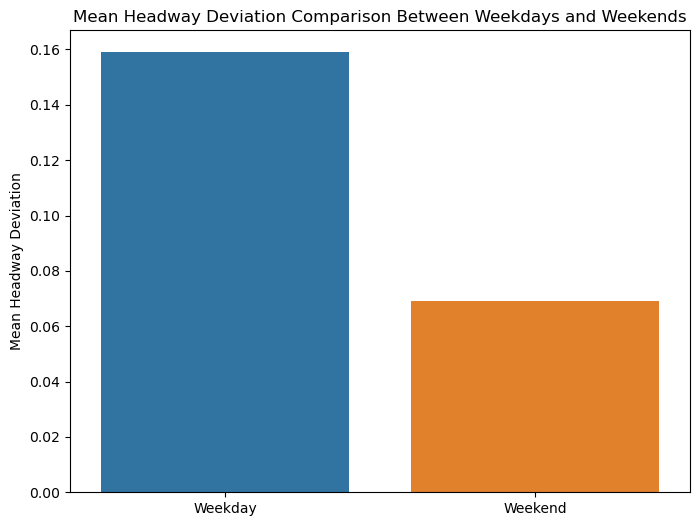

In [29]:
# Filter data for weekdays and weekends
weekday_data = processed_data[processed_data['Day_Type'] == 'Weekday']
weekend_data = processed_data[processed_data['Day_Type'] == 'Weekend']

# Set up the data for plotting
data_to_plot = [weekday_data['HDWY_DEV'], weekend_data['HDWY_DEV']]

# Create a bar plot with error bars
plt.figure(figsize=(8, 6))
sns.barplot(x=['Weekday', 'Weekend'], y=[data.mean() for data in data_to_plot], errcolor='gray', capsize=0.2)
plt.ylabel('Mean Headway Deviation')
plt.title('Mean Headway Deviation Comparison Between Weekdays and Weekends')

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/wego_project/images/mean_hdwy_dev_comparison_types_of_day.png');
plt.show()

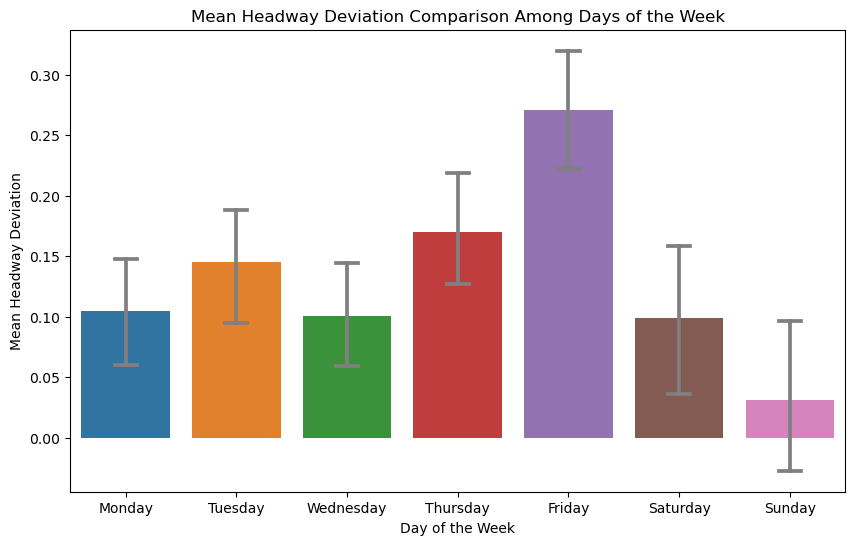

In [30]:
# Create a bar plot with error bars
plt.figure(figsize=(10, 6))
sns.barplot(x='Day_of_Week', y='HDWY_DEV', data=processed_data, errcolor='gray', capsize=0.2)
plt.ylabel('Mean Headway Deviation')
plt.xlabel('Day of the Week')
plt.title('Mean Headway Deviation Comparison Among Days of the Week')
# plt.xticks(rotation=45)  # Rotate x-axis labels for readability

# Dictionary for custom x tick labels 
day_order = {
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday',
    7: 'Sunday'
}

# Set custom x-axis labels
custom_labels = [day_order[i] for i in range(1, 8)]
plt.xticks(range(7), custom_labels)

# plt.savefig('C:/Users/MJ/Data Science Bootcamp/Projects/temp/images/mean_hdwy_dev_comparison.png');
plt.show();

**Question:** Are there specific days that have a wide range of deviation from headway? 

In [31]:
# Encode 'Day_Type' as a categorical variable
processed_data['Day_Type'] = processed_data['Day_Type'].astype('category')

# Create dummy variables for 'Day_Type' (one-hot encoding)
day_type_dummies = pd.get_dummies(processed_data['Day_Type'], prefix='Day_Type')

# Add the dummy variables to the DataFrame
processed_data = pd.concat([processed_data, day_type_dummies], axis=1)

In [32]:
lm = smf.ols('HDWY_DEV ~ Day_Type_Weekday + Day_Type_Weekend', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     13.70
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           0.000214
Time:                        11:20:00   Log-Likelihood:            -7.5907e+05
No. Observations:              254299   AIC:                         1.518e+06
Df Residuals:                  254297   BIC:                         1.518e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0760      0.008      9.373      0.000       0.060       0.092
Day_Type_Weekday     0.0830      0.010      8.191      0.000       0.063       0.103
Day_Type_Weekend    -0.0070      0.015     -0.467      0.640      -0.036       0.022
==============================================================================
Omnibus:                    19977.617   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70186.392
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       5.470   Cond. No.                     5.05e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.73e-26. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

**Interpretation:**

- The model does not explain much of the variance in 'HDWY_DEV' as indicated by the low R-squared value.
- The **'Day_Type_Weekday' coefficient is statistically significant (p-value is 0.000),** suggesting that 'Day_Type' has an influence on 'HDWY_DEV' on weekdays.
- The 'Day_Type_Weekend' coefficient is not statistically significant (p-value is 0.640), suggesting that 'Day_Type' does not have a statistically significant influence on 'HDWY_DEV' on weekends.
- The presence of significant multicollinearity issues is indicated by the small eigenvalue.

In [33]:
lm = smf.ols('HDWY_DEV ~ Day_of_Week', data = processed_data).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               HDWY_DEV   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.1545
Date:                Mon, 13 Nov 2023   Prob (F-statistic):              0.694
Time:                        11:20:01   Log-Likelihood:            -7.5907e+05
No. Observations:              254299   AIC:                         1.518e+06
Df Residuals:                  254297   BIC:                         1.518e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.1346      0.021      6.329      0.000       0.093       0.176
Day_of_Week     0.0020      0.005      0.393      0.694      -0.008       0.012
==============================================================================
Omnibus:                    19983.271   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            70349.799
Skew:                           0.362   Prob(JB):                         0.00
Kurtosis:                       5.473   Cond. No.                         9.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation:** 

The results suggest that the "Day_of_Week" variable does not have a significant impact on explaining the variation in "HDWY_DEV." The model is not a good fit for the data, and there is no evidence to support a strong relationship between the day of the week and headway deviation based on this analysis.

C:\Users\MJ\AppData\Local\Temp\ipykernel_14052\2633960425.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='Day_of_Week', y='HDWY_DEV', data=processed_data, palette='viridis', alpha=0.7)


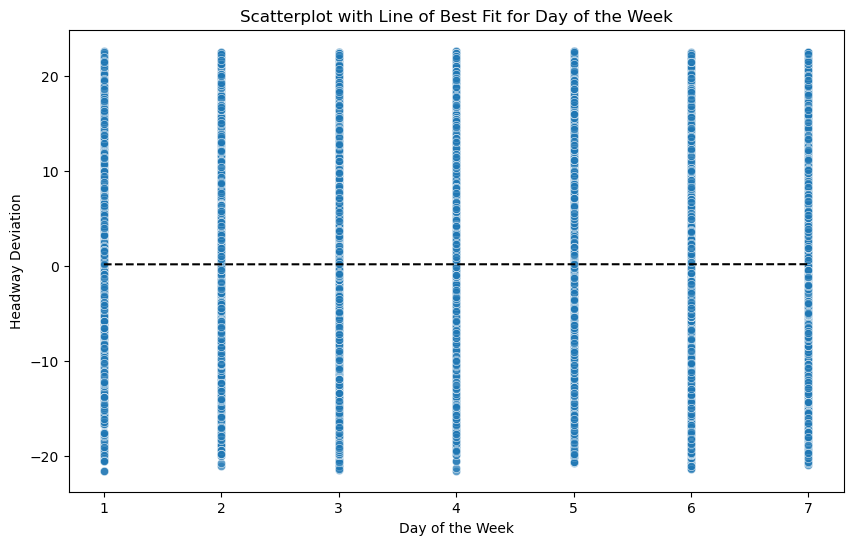

In [34]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Day_of_Week', y='HDWY_DEV', data=processed_data, palette='viridis', alpha=0.7)

# Fit a line of best fit for the entire dataset
model = sm.OLS(processed_data['HDWY_DEV'], sm.add_constant(processed_data['Day_of_Week'])).fit()

# Generate x values for the line
x_values = np.linspace(processed_data['Day_of_Week'].min(), processed_data['Day_of_Week'].max(), 100)

# Calculate y values based on the regression model
y_values = model.predict(sm.add_constant(x_values))

# Plot the line of best fit with black color
plt.plot(x_values, y_values, linestyle='--', color='black')

plt.xlabel('Day of the Week')
plt.ylabel('Headway Deviation')
plt.title('Scatterplot with Line of Best Fit for Day of the Week')
plt.show()

In [35]:
bna_weather = pd.read_csv("../data/bna_weather.csv")
bna_weather.head(4)

,STATION,NAME,DATE,AWND,PGTM,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT08
0,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-01,6.49,NaN,0.00,0.0,0.0,80,89,70,50,10,13.0,21.0,NaN,NaN,NaN,NaN
1,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-02,2.91,NaN,0.00,0.0,0.0,77,86,65,150,180,8.1,12.1,NaN,NaN,NaN,NaN
2,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-03,4.92,NaN,1.19,0.0,0.0,77,81,72,230,300,12.1,29.1,1.0,NaN,1.0,NaN
3,USW00013897,"NASHVILLE INTERNATIONAL AIRPORT, TN US",2023-08-04,2.24,NaN,0.12,0.0,0.0,78,84,73,270,40,8.9,14.1,1.0,NaN,NaN,NaN


In [36]:
Transit_Bus_Stops = pd.read_csv("../data/WeGo_Transit_Bus_Stops_20231025.csv")
Transit_Bus_Stops.head(4)

,Stop ID,Stop Abbreviation,Stop Name,Shelter?,Bench?,Route Numbers,Route Name,Mapped Location
0,5120,7AVUNINN,7TH AVE & UNION ST NB,False,False,NaN,AIRPORT - DOWNTOWN HOTELS,NaN
1,5455,CM5_4,Temporary Bay 4,False,False,NaN,HERMAN,NaN
2,2762,23ACLASF,23RD AVE N & CLARKSVILLE PIKE SB,False,False,22,BORDEAUX,NaN
3,4079,21ACHUSN,21ST AVE N & CHURCH ST SB,False,True,25,MIDTOWN,NaN


**Question:** How does times of day and day impact headway deviation? 